In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as sts
import stan
import nest_asyncio
import matplotlib.pyplot as plt
nest_asyncio.apply() 

## Introduction 

It is no secret that the response of multiple countries following the outbreak of the COVID-19 pandemic has been abismal - and the UK is no exception. With £355 billion amounting in economic losses (OBR, 2021), a 4.8% rate of unemployment (ONS, 2021) and, perhaps most shockingly, over 128,000 deaths to this date (Gov.uk, 2021), the UK government has undoubtedly handled this crisis poorly, with two key government-led programmes standing out amongst the list of policy failures. 

The Test and Trace programme, established to curb Coronavirus reproduction, aims to provide accessible testing as well as contact tracing to notify exposed individuals and instruct them to self-isolate. One major failure of the T&T programme has been the lack of a coherent data collection strategy for analysing setting-specific transmission; that is, the relative likelihood of contracting COVID in different locations, such as a hair dresser, a restaurant, etc. Given the dependence of the UK Tier System on our understanding of setting-specific transmission, this alone serves as an explanation of the latter's failure, as settings grouped together often bear no resemblance in terms of their underlying transmission rates, resulting in unnecessary business closures and contributing to the economic hemorrhage.

Thus, we set out to formulate a data collection and analysis methodology that is both compatible with the current T&T programme and enables us to model and estimate setting-specific COVID-19 transmission rates, in the hope of guiding lockdown policies using a reliable, data-driven approach.

## Our approach and assumptions

### Data collection methodology
Starting out, our goal was to model a random vector $\boldsymbol{\theta} \in [0,1]^P$ of transmission rates for $P$ different settings. To estimate this model, we would require data that could be feasibly collected through the T&T programme. Therefore, we devised the following data collection strategy to accompany the probabilistic model developed below, making sure to prioritize its feasibility and scalability:

1. Data is to be collected from individuals in the T&T programme through a short survey of binary responses on whether or not they visited each one of $P$ locations in the last few days.

2. For each individual surveyed through T&T, the result of their COVID-19 antigen test is also observed.

3. Finally, a random survey is also sent out. This survey is identical to the one in (1.) but, since it is not distributed by T&T, no antigen test is taken and therefore no outcome is observed.


### Model assumptions
In order for us to combine this data collection methodology with a statistical model that allows for inference on the estimated setting-specific transmission rates, we had to lay down the following assumptions:

- Multiple visits to a location in one week are rare enough to be ignored or in cases (such as supermarkets) where multiple visits are expected, the distribution of number of visits is tight.

## Building a first-principles model

Given the data collection strategy detailed above, for each individual, we observe a binary vector $\boldsymbol{x}_i \in \{0,1\}^{P}$, which indicates their responses on the location visits survey, and random variable $y_i \in \{0,1\}$ which indicates if they tested positive for COVID-19.

### The base model

We formulate our model generatively through the latent transmission vector $\boldsymbol{t}_i \in \{0,1\}^{P}$, which follows a multivariate Bernoulli distribution with transmission probabilities dependent on the individual's attendance to each setting and the respective setting-specific transmission rates. Furthermore, we capture the case of COVID transmission in a location not specified by the survey through the latent variable $b_i \in \{0,1\}^{P}$, which is analogous to $\boldsymbol{t}_i$, but parameterized by the underlying base transmission risk: 

$$\boldsymbol{t}_i \sim \text{Ber}(\boldsymbol{x}_i \circ \boldsymbol{\theta})$$

$$b_i \sim \text{Ber}(\rho)$$

We denote whether or not the individual contracted COVID-19 with the binary variable $w_i$ and define it using the natural relationship with the aforementioned latent variables. Since transmission in any of the settings surveyed or in some other unaccounted location results in contraction, we define $w_i$ as the indicator of this scenario:

$$w_i=\mathbb{1}\{\textbf{1}^\text{T}\boldsymbol{t}_i + b_i>0\}$$

### Curbing selection bias

The next challenge for our model was to account for selection bias in T&T survey observations. More specifically, infected individuals (who feel unwell and present symptoms) are more likely to get in contact with T&T and hence select into the survey, thus introducing bias into any transmission rate estimates. To mitigate this, we collect observations of $\boldsymbol{x}_i$ from a random survey and define $s_i$ to indicate whether or not the observation came from T&T:
$$s_i=\begin{cases} 
            1,\; \text{T\&T sample} \\
            0,\; \text{otherwise}
            \end{cases}$$
            
From there, we utilize $s_i$ to define the testing rates as the probability of getting tested conditional on being COVID-19 infected, and use these to weight down the transmission likelihood for our observations.


$$ \mathbb{P}(s_i=1|w_i=1) = \gamma_+ $$
$$ \mathbb{P}(s_i=1|w_i=0) = \gamma_- $$

### Addressing inaccurate tests

Similarly, we also account for false positive and negative antigen test results by defining the test sensitivity and specificity parameters through the conditional probability of testing positive given infected and testing negative given non-infected, respectively:

$$\mathbb{P}(y_i=1|w_i=1) = \lambda_+$$

$$\mathbb{P}(y_i=0|w_i=0) = \lambda_-$$

### Hierarchical extension

We modeled the hierarchical nature of setting-specific transmission by grouping each setting into one of $K$ encompassing classes of similar settings: $c[p]:[P] \to [K]$. For each class, we model transmission rates of member settings as draws from a [logit-normal](https://en.wikipedia.org/wiki/Logit-normal_distribution) distribution, parameterized by the mean class transmission rate $\boldsymbol{\mu} \in [0,1]^K,$ and the class transmission rate variance $\, \boldsymbol{\sigma}^2 \in \mathbb{R}_{>0}^K$. It should be noted that :

$$\theta_p \sim \text{Logitnormal}\left(\text{logit}\left(\mu_{c[p]}\right) \;,\; \sigma_{c[p]}^{2} \right)$$


### Modelling policy interventions

Finally, we also wanted to model the effect of policy interventions on different setting classes to answer questions such as: *"Does social distancing have different effects in cinemas than in restaurants?"* To do this, we can introduce policy intervention parameters and model out their interactions with different setting transmission rates, provided our data collection methodology can be feasibly extended to collect the data necessary to pin down these additional parameters. 

We exemplify this with the mask-wearing intervention, with the objective of estimating the different effects mask-wearing can have in different settings. To do this, we could extend our data collection survey to ask individuals about their mask-wearing habits, allowing us to define $m_i$ as an indicator for habitual mask-wearers:

$$m_i=\begin{cases} 
            1,\; \text{habitual mask-wearing} \\
            0,\; \text{otherwise}
            \end{cases}$$
 
 
This additional data then allows us to incorporate and estimate $\iota_{c[p]}$ as the class-specific mas wearing impact on transmission rates: 
 
 
$$\theta_{ip} \sim \text{Logitnormal}\left(\, \text{logit}\left(\mu_{c[p]}\right) + m_i \log\left(\iota_{c[p]}\right) \;,\; \sigma_{c[p]}^{2} \,\right)$$ 

Modeling policy interventions in this way allows for a clear-cut interpretation of the intervention effect parameter. More specifically, with a little algebra, it becomes evident that $\iota_{c[p]}$ essentially acts as a multiplier effect on the average class transmission odds:

$$\log\left(\frac{\mu_{c[p]}}{1-\mu_{c[p]}} \right) \rightarrow \log\left(\iota_{c[p]} \frac{\mu_{c[p]}}{1-\mu_{c[p]}} \right)$$

## Simulating our data

### Metadata
In order to be test out this model, the following metadata must be defined in relation to the application context:
- $P:$ A vector containing the number of settings per class
- $K:$ The number of setting classes considered in the model 
- $N:$ The total population
- $S:$ The number of random surveys sent out
- $T:$ The total number of T&T samples

In particular, it is worth highlighting that $N,S,$ and $T$ are constrained by the following:

$$N \geq S+T$$

It is assumed that, in the typical case, both $N$ and $T$ are predetermined, and the authority applying the model gets to choose $S$ subject to the above. In our simulation, $N$ and $S$ are pre-set and $T$ is randomly determined given the simulated testing rates.

In [2]:
#### METADATA ####
P = [3, 5, 1, 4, 1, 2, 1, 1, 4]    # Number of settings per class 
N = 10000                          # Total population
S = 8000                           # Number of random surveys sent out
SEED = 1729                        # Random seed

### Population ground truth
Since we our data collection strategy is (an ideal) hypothetical, to test our model we must first specify a ground truth for the population parameters and then simulate our data accordingly. To this end we sampled our population parameters as follows, making sure to try a range of values for these to ensure model robustness:

|Parameter                       |Model Notation|Simulation|Model Priors|
|--------------------------------|------------------|----------|------------|
|Setting transmission rates      |$\theta_{ip}$     |Logit-normal distribution parameterized by class transmission rate mean and variance| $U(0,1)$ |
|Mean class transmission rates   |$\mu_{c[p]}$      |Beta distribution|$U(0,1)$|
|Class transmission rate variance|$\sigma^2_{c[p]}$ |Inverse gamma distribution|$\text{Inv-Gamma}(10, 1)$|
|Base transmission rate          |$\rho$            |Beta distribution|$U(0,1)$|
|Class-specific mask impact      |$\iota_{c[p]}$    |Normal with negative mean|$\mathcal{N}(-1, 1)$|
|Testing rates                   |$\gamma_{+,\,-}$          |Beta distribution|$U(0,1)$|
|Test precision and recall rates |$\lambda_{+,\,-} $         |Beta distribution|$\text{Beta}(\alpha*, \beta*)$, with shape hyperparameters calibrated to match the antigen test sensitivity and specificity results from the [Joint PHE Porton Down & University of Oxford SARS-CoV-2 test development and validation cell](https://www.ox.ac.uk/sites/files/oxford/media_wysiwyg/UK%20evaluation_PHE%20Porton%20Down%20%20University%20of%20Oxford_final.pdf)|

In [3]:
#### GROUND TRUTH ####
np.random.seed(SEED)

# Mask-wearing individual indicator: Simulated from a binomial distribution
mask_wearer = np.random.binomial(1, 0.5, size=(N,))

# Log-mask impact: Simulated from a log-normal distribution for every class
true_iota = np.random.lognormal(-1, 0.5, len(P))
true_iota_rep = np.repeat(true_iota, P)

# Testing rates: Simulated from a beta distribution 
gamma_plus = np.random.beta(8, 2, 1)    # Prob(tested | infected)
gamma_minus = np.random.beta(2, 20, 1)  # Prob(tested | not-infected)
true_gamma = np.array([gamma_plus, gamma_minus])

# Test accuracy: Simulated from a beta distribution 
lambda_plus = np.random.beta(4, 3, 1)    # Test sensitivity
lambda_minus = np.random.beta(50, 2, 1)  # Test specificity
true_lambda = np.array([lambda_plus, lambda_minus])

# Transmission rates:
# - Mean setting class rates are simulated from a beta distribution
# - Setting class rate variance is simulated from an inverted gamma disribution
# - Transmission rates for individual places are formed by taking the logit 
#   mean class rate, adding some random gaussian noise, and then mapping back
#   onto the (0,1) domain by taking the expit function
true_mu = np.random.beta(2, 10, len(P))
true_sigma = np.sqrt(sts.invgamma.rvs(a=100, size=len(P)))
true_theta = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_mu, true_sigma)
])

# Base transmission rate: Simulated from a beta distribution
true_rho = np.random.beta(2, 10, 1)

# Occurrence rates: 
# - These are the rates at which individuals visited different settings
# - Simluated from a beta distribution
true_occurrence_rate_mu = np.random.beta(2, 10, len(P))
true_occurrence_rate_std = np.sqrt(sts.invgamma.rvs(a=50, size=len(P)))
true_occurrence_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_occurrence_rate_mu, true_occurrence_rate_std)
])

In [4]:
# Antigen test mean and std. error for TP and TN rates (for strong priors)

# True positive
mean_tp = 0.73000
se_tp = 0.04133

# True negative
mean_tn = 0.99680
se_tn = 0.00066

mean_rates = [mean_tp, mean_tn]
se_rates = [se_tp, se_tn] 

alphas = [(((1 - m)/s**2)-(1/m)) * (m**2) for m,s in zip(mean_rates,se_rates)]
betas = [a*((1/m)-1) for m,a in zip(mean_rates, alphas)] 
    
prior_params = np.array([alphas, betas]).T 

In [5]:
#### DATA SIMULATION ####
# Simulate visits and transmissions
data = {}
for p in range(sum(P)):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    # Impact of mask-wearing
    transmission_prob = sp.expit(sp.logit(true_theta[p]) +
                                 np.log(true_iota_rep[p]) * mask_wearer)
    transmission = occurrence * np.random.binomial(1, transmission_prob)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, true_rho, N)
X = pd.DataFrame(data)

# Simulate contractions
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
w = (z > 0).astype(int)

# Record classes
c = np.array([i + 1 for i, p in enumerate(P) for __ in range(p)])

# Defining tested indicator 
tested = w*np.random.binomial(1, true_gamma[0], N) +\
         (1-w)*np.random.binomial(1, true_gamma[1], N)

# Separating survey samples
if S >= (N - tested.sum()):
    X_survey = X[tested == 0] 
    m_survey = mask_wearer[tested == 0] 
else:
    X_survey = X[tested == 0].sample(S, random_state=SEED) 
    m_survey = mask_wearer[X_survey.index]

# Separating T&T samples    
X = X[tested == 1] 
m = mask_wearer[tested == 1] 

#
T = X.shape[0]
S = X_survey.shape[0]

# Removing occurence columns
X = X.loc[:, X.columns.str.startswith('O')]
X_survey = X_survey.loc[:, X_survey.columns.str.startswith('O')] 

# Filter out untested observations
y = w[tested == 1] 

# Introduce false positives and negatives
y = y * np.random.binomial(1, true_lambda[0], T) +\
    (1-y) * np.random.binomial(1, (1-true_lambda[1]), T)

# Record classes
c = np.array([i + 1 for i, p in enumerate(P) for __ in range(p)])

X = X.loc[:, X.columns.str.startswith('O')]
X_survey = X_survey.loc[:, X_survey.columns.str.startswith('O')] 

## Fitting our Model

### Our model in Stan

We implemented the code for our first-principles model using Stan, a probabilistic inference language compiled in C++. Stan allows users to carry out full Bayesian inference on statistical models via Markov Chain Monte Carlo (MCMC) sampling, and enables model specification in a block-like fashion. The main building blocks for our Stan model are:
1. The data block, which specifies the type and dimensions of data used to train the model.
2. The parameter block, which specifies all underlying statistical parameters of the model.
3. The model block, which assigns parameter priors and constructs the model likelihood describing the joint probability of the observed data as a function of the parameters.

With computational feasibility in mind, we also coded a version of our model using the TensorFlow Probability framework, as this version supports the use of GPU's and distributed computing capabilities to deliver greater computational power. For a more extensive review of the code produced, please refer to the project [GitHub repository.](https://github.com/THargreaves/reinventing-test-and-trace) 

``` Stan
model_code = """
functions {
  real expit_gaussian_lpdf(real y, real logit_mu, real sigma2) {
    return log(1 / y + 1 / (1 - y)) - (logit(y) - logit_mu)^2 / (2 * sigma2);
  }
}
data {
  int<lower=0> T;                            // number of T&T observations
  int<lower=0> S;                            // number of survey observations
  int<lower=0> P;                            // number of settings
  int<lower=0> K;                            // number of classes
  int<lower=0, upper=1> X[T,P];              // activity occurrences
  int<lower=0, upper=1> y[T];                // transmission (tested positive)
  int<lower=0, upper=1> survey[S,P];         // activity occurrences of surveyed individuals
  real lambda_prior_params[2,2];             // shape parameters for TP/TN test rate priors
  int<lower=1, upper=K> c[P];                // setting classes
  int<lower=0, upper=1> m[T];                // masking-wearing
  int<lower=0, upper=1> m_survey[S];         // masking-wearing
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> mu[K];              // class transmission means
  real<lower=0> sigma2[K];                   // class transmission variances
  real<lower=0, upper=1> gamma[2];           // Testing rates, given infected status [s|w , s|!w]
  real<lower=0, upper=1> lambda[2];          // True positive and true negative rates of tests [TP,TN]
  real<lower=0, upper=1> rho;                // underlying risk
  real iota[K];                              // intervention impacts (log)
}
transformed parameters {
  // Pre-computation for efficiency
  real log1m_theta[P] = log1m(theta);
  real log1m_theta_int[P];
  real log1m_rho = log1m(rho);
  real logit_mu[K] = logit(mu);
  real log_gamma[2];
  real log1m_gamma[2];
  real log_lambda[2];
  real log1m_lambda[2];

  for (p in 1:P) {
    log1m_theta_int[p] = log1m_inv_logit(logit(theta[p]) + iota[c[p]]);
  } 
  
  log1m_theta = log1m(theta); 
  log_gamma = log(gamma);
  log1m_gamma = log1m(gamma);
  log_lambda = log(lambda);
  log1m_lambda = log1m(lambda);
}
model {
  // Priors
  //mu ~ beta(1, 5);
  mu ~ uniform(0, 1);
  sigma2 ~ inv_gamma(10, 1);
  rho ~ beta(1, 3);
  iota ~ normal(-1, 1);
  gamma ~ uniform(0, 1);
  lambda[1] ~ beta(lambda_prior_params[1,1],lambda_prior_params[1,2]);
  lambda[2] ~ beta(lambda_prior_params[2,1],lambda_prior_params[2,2]);
  
  // Likelihood (classes)
  for (p in 1:P) {
    theta[p] ~ expit_gaussian(logit_mu[c[p]], sigma2[c[p]]);
  }
  
  // Likelihood (survey)
  for (n in 1:S) {
    real s = 0.0;
    for (p in 1:P) {
      if (survey[n,p] == 1) {
        if (m_survey[n] == 1) {
          s += log1m_theta_int[p];
        } else {
          s += log1m_theta[p];
        }
      }
    }
    s += log1m_rho;
    target += log_sum_exp((log1m_exp(s)+log1m_gamma[1]), (s+log1m_gamma[2]));
  }
  // Likelihood (T&T observations)
  for (n in 1:T) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        if (m[n] == 1) {
          s += log1m_theta_int[p];
        } else {
          s += log1m_theta[p];
        }
      }
    }
    s += log1m_rho;
    if (y[n] == 1) {
      target += log_sum_exp((log1m_exp(s) + log_gamma[1] + log_lambda[1]), (s + log_gamma[2] + log1m_lambda[2]));
    } else {
      target += log_sum_exp((s + log_gamma[2] + log_lambda[2]), (log1m_exp(s) + log_gamma[1] + log1m_lambda[1]));
    }
  }
}
"""
```

### Markov Chain Monte Carlo Posterior Sampling

In general, the aim of Bayesian inference is to derive the posterior distribution of our parameters by defining it mathematically using Bayes' theorem as below, where $p(\theta)$ is the parameter prior and $p(\boldsymbol{X}\,|\,\theta )$ is the model likelihood:

$$p(\theta \,|\,\boldsymbol{X}) \;=\; \frac{p(\theta) \, p(\boldsymbol{X}\,|\,\theta )}{p( \boldsymbol{X})}$$

Unfortunately, this distribution in our model (as is the case for most Bayesian models) cannot be evaluated analytically given the highly-dimensional parameter space. To overcome this, Stan utilizes the NUTS algorithm (part of the general class of MCMC methods) to infer the posterior distribution by repeatedly drawing samples from it, even though its full closed-form characterization is unknown. Unlike regular Monte Carlo sampling, which draws independent samples, MCMC allows for 'smarter' sampling as it draws correlated samples from the stationary distribution of a Markov chain that's proportional to the desired distribution. This allows for the sampling process to enter regions of high density much faster. For more details regarding how Stan achieves this using the NUTS algorithm, the interested reader should refer to [this link.](https://mc-stan.org/docs/2_18/reference-manual/hmc-chapter.html) 

At its core, there are three hyperparamters that need to be specified for MCMC sampling with the NUTS algorithm.
Firstly, the `num_warmup` parameter is used to specify the number of samples that are discarded as burn-in. This is done in order to allow convergence onto the stationary distribution of the Markov chain. Secondly, the `n_samples` parameter specifies the number of samples to be drawn from the distribution. Finally, `n_chains` specifies the number of chains that should be constructed, as using more well-mixed chains increases robustness. 

In [8]:
### MCMC SAMPLING HYPERPARAMETERS ####
ITER = 1000
WARMUP = 500
CHAINS = 8
SEED = 1729

#### MODEL FITTING ####
# Define model data
model_data = {
    'T': T, 'S': S, 'P': sum(P), 'K': len(P),
    'X': X.to_numpy(), 'y': y.to_numpy(), 'c': c, 'm': m, 'm_survey': m_survey,
    'survey': X_survey.to_numpy(), 'lambda_prior_params':prior_params,
}

# Compile model
posterior = stan.build(model_code, data=model_data, random_seed=1)

# Fit model
fit = posterior.sample(num_samples=ITER, num_warmup=WARMUP, num_chains=CHAINS)

Building...



Building: found in cache, done.Messages from stanc:


## Results and conclusion

### Visualizing posterior samples

After running our model, we computed the summary statistics of our posterior samples in the table below. Additionally, we visualize these in the subsequent traceplots, which show the distributions for all $P$ setting transmission rates, as well as the other model parameters, in the left, and the sampled values on the right. Overall, we can see that there was proper chain mixing given both the shape of our sampled value traces and the $\hat{R}$ statistics (equal to one for all model parameters), which suggests that improper model parametrization is unlikely to be an issue. 

In [129]:
# Summary of posterior samples
params = ['theta', 'rho', 'mu', 'sigma2', 'iota', 'gamma', 'lambda']
arviz.summary(fit, var_names=params) 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],0.250,0.111,0.042,0.444,0.002,0.001,4090.0,4090.0,3711.0,3200.0,1.0
theta[1],0.224,0.101,0.042,0.410,0.002,0.001,4116.0,4116.0,3688.0,3103.0,1.0
theta[2],0.212,0.098,0.040,0.390,0.001,0.001,4352.0,4352.0,3834.0,3492.0,1.0
theta[3],0.228,0.098,0.053,0.404,0.002,0.001,2733.0,2733.0,2720.0,3567.0,1.0
theta[4],0.231,0.099,0.066,0.420,0.002,0.001,2788.0,2787.0,2807.0,3854.0,1.0
theta[5],0.223,0.097,0.062,0.410,0.002,0.001,2890.0,2877.0,2818.0,3744.0,1.0
theta[6],0.267,0.108,0.080,0.471,0.002,0.001,2956.0,2956.0,2817.0,3703.0,1.0
theta[7],0.262,0.110,0.076,0.470,0.002,0.002,2323.0,2323.0,2254.0,3422.0,1.0
theta[8],0.189,0.127,0.000,0.408,0.002,0.001,5756.0,5756.0,4251.0,2878.0,1.0
theta[9],0.314,0.088,0.153,0.476,0.001,0.001,4434.0,4431.0,4447.0,5614.0,1.0


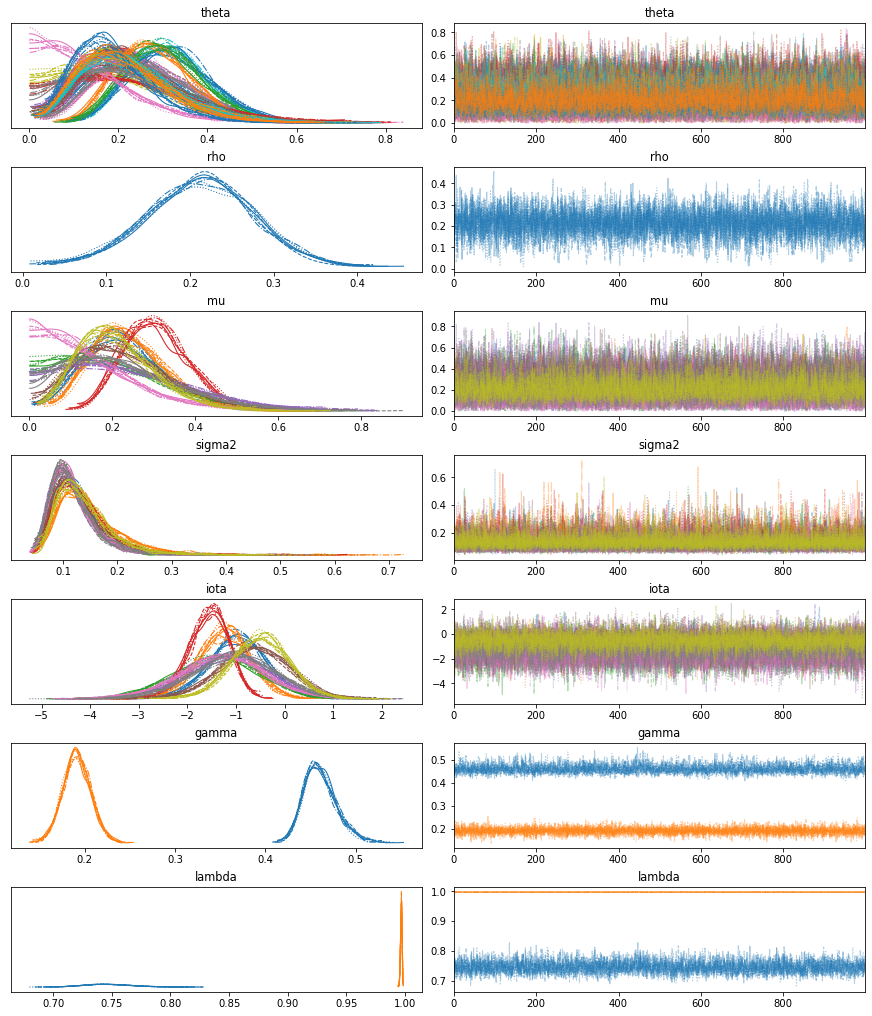

In [112]:
# Evaluate posterior traceplots
arviz.plot_trace(fit, var_names=params);

### Comparison with ground truth 

After fitting, one key question is the extent to which our model is successful in estimating the underlying transmission rates. To test this, we take the posterior mean as the [minimum mean squared error estimate](https://en.wikipedia.org/wiki/Bayes_estimator) and compare it to the ground-truth parameters used to simulate the data-generating process. As shown in the table below, most parameter estimates fall reasonably close from the actual ground truth values, and all of them fall within the 94% high density interval (HDI), serving as a good indicator of our model's accuracy. 

The key condition for this comparison as proof-of-concept is the fact that our model only observes the parameter priors and the training data, but never the simulating distributions themselves. Moreover, excluding the case of antigen test accuracy rates, the priors as specifically chosen to be largely uninformative relative to the simulating distribution in order to limit the unreasonable influence of these on model performance.

Finally, a question of interest is how the accuracy of the model is affected by the number of training samples or the dimension of the parameter space. The results for both of these questions are excluded for brevity, but they tend to fall in line with what would be expected (model accuracy increases with training data and decreases with dimensionality) and the interested reader should consult the project repository for more details.

In [128]:
ground_truth = pd.DataFrame(np.concatenate([true_theta.reshape(-1,1),
                                            true_rho.reshape(-1,1),
                                            true_mu.reshape(-1,1),
                                            true_sigma.reshape(-1,1),
                                            np.log(true_iota.reshape(-1,1)),
                                            true_gamma.reshape(-1,1),
                                            true_lambda.reshape(-1,1)])) 
est = arviz.summary(fit, var_names=params)[['mean', 'hdi_3%', 'hdi_97%']].reset_index() 
comparison = ground_truth.join(est) 
comparison.rename(columns={0: "Ground Truth", 
                           "mean": "Posterior Mean",
                           "hdi_3%": "HDI 3%", 
                           "hdi_97%": "HDI 97%",
                           "index": "Parameter"}, inplace=True)
comparison.set_index('Parameter')

,Ground Truth,Posterior Mean,HDI 3%,HDI 97%
Parameter,,,,
theta[0],0.125388,0.250,0.042,0.444
theta[1],0.129571,0.224,0.042,0.410
theta[2],0.127706,0.212,0.040,0.390
theta[3],0.121898,0.228,0.053,0.404
theta[4],0.141731,0.231,0.066,0.420
theta[5],0.141376,0.223,0.062,0.410
theta[6],0.116330,0.267,0.080,0.471
theta[7],0.140423,0.262,0.076,0.470
theta[8],0.159181,0.189,0.000,0.408


### Conclusion and future work

This project aimed to understand & model the nature of setting-specific COVID transmission with the purpose of informing and improving related policy interventions. The first-principles model presented in this article allows us to do this in a way that properly captures the data-generating process behind setting-specific transmission, all with considerations of a simple and feasible data collection methodology. Furthermore, the Bayesian nature of our model allows flexibility when incorporating expert knowledge through priors, as exemplified with the calibrated antigen test accuracy parameters, and provides accurate estimates even with few training samples thanks to its generative nature. Finally, from an implementation perspective, our model is built with scalability in mind, as the TensorFlow Probability version makes it feasible for large-scale applications with the aid of distributed computing architecture. 

There is still much left to be done and many possible extensions could be added to make our model more robust and powerful. One possible angle for future work would be extending the model to encapsulate the effect of other policy interventions (such as social distancing regulations, vaccination, etc.) in order to derive insights about the effectiveness of these in different settings. Another possible extension could be to add temporal dynamics into the model by combining with an SIR-type model. 

Overall, we believe this model serves as a great case for statistical modeling of setting-specific epidemic transmission, with great potential for future extensions and applications to similar settings. Additionally, it serves as a great example of the power of Bayesian modelling and the many benefits it can bring in applied settings.